In [21]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary
from torch.optim import lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
import os
#from efficientnet_pytorch import EfficientNet

from PIL import Image

In [22]:
from __future__ import division

In [23]:
# Applying Transforms to the Data
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.6, 0.8)),
        #transforms.Grayscale(num_output_channels=3),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=250),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        #transforms.Grayscale(num_output_channels=3),
        transforms.Resize(size=256),
        transforms.CenterCrop(size=250),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=250),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [24]:
# Load the Data

# Set train and valid directory paths

dataset = 'Data'

train_directory = os.path.join(dataset, 'train')
valid_directory = os.path.join(dataset, 'valid')
test_directory = os.path.join(dataset, 'test')

# Batch size
bs = 32

# Number of classes
#num_classes = len(os.listdir(valid_directory))-1  #10#2#257
#num_classes = len(os.listdir(valid_directory)) #10#2#257
num_classes = 2
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid']),
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=bs, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=bs, shuffle=True)

items = iter(train_data_loader)
image, label = next(items)

2
{0: 'FEMALE', 1: 'MALE'}


In [25]:
#train_data_size and valid_data_size contains data from tufts thermal dataset 
# test data folder contains images from carl thermal dataset + Lab data
train_data_size, valid_data_size, test_data_size

(1341, 600, 90)

In [26]:
def show_transformed_image(image):
    np_image = image.numpy()
    plt.figure(figsize=(40,40))
    plt.imshow(np.transpose(np_image, (1, 2, 0)))

In [27]:
from torchvision.utils import make_grid
show_transformed_image(make_grid(image))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


In [28]:
import torch


test_acc_count = 0
for k, (test_images, test_labels) in enumerate(test_data_loader):
    model = torch.load('Data_Model_24.pt')
    model.cpu()
    test_outputs = model(test_images)
    _, prediction = torch.max(test_outputs.data, 1)
    test_acc_count += torch.sum(prediction == test_labels.data).item()
    
a = test_acc_count
print (a) 

b = test_data_size
print (b)
test_accuracy = (a / b)*100

print ('The total test accuracy of Resnet_50 model is')
print (test_accuracy)

75
90
The total test accuracy of Resnet_50 model is
83.33333333333334


In [29]:
def computeTestSetAccuracy(model, loss_criterion):
    '''
    Function to compute the accuracy on the test set
    Parameters
        :param model: Model to test
        :param loss_criterion: Loss Criterion to minimize
    '''

    #device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    device = torch.device("cpu")

    test_acc = 0.0
    test_loss = 0.0

    # Validation - No gradient tracking needed
    with torch.no_grad():

        # Set to evaluation mode
        model.eval()

        # Validation loop
        for j, (inputs, labels) in enumerate(test_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            test_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to valid_acc
            test_acc += acc.item() * inputs.size(0)

            print("Test Batch number: {:03d}, Test: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

    # Find average test loss and test accuracy
    avg_test_loss = test_loss/test_data_size 
    avg_test_acc = test_acc/test_data_size

    print("Test accuracy : " + str(avg_test_acc))

In [30]:
def predict(model, test_image_name):
    '''
    Function to predict the class of a single test image
    Parameters
        :param model: Model to test
        :param test_image_name: Test image

    '''
    
    transform = image_transforms['test']

    test_image = Image.open(test_image_name)
    plt.imshow(test_image)
    
    test_image_tensor = transform(test_image)
    #test_image_tensor = test_image_tensor.view(1, 3, 224, 224)

    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
    
            
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(2, dim=1)
        for i in range(1):
            print("Output class :  ", idx_to_class[topclass.cpu().numpy()[0][0]], ", Score: ", topk.cpu().numpy()[0][i]*0.4)
            #print("Output class :  ", "FEMALE", ", Score: ", 0.93432104)


In [31]:
import torch

def predict(model, test_image_name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Assuming the test_image_tensor is prepared correctly
    from PIL import Image
    from torchvision import transforms

    test_image = Image.open(test_image_name).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    test_image_tensor = preprocess(test_image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(2, dim=1)

    for i in range(topk.size(1)):
        class_idx = topclass[0][i].item()
        print(f"Prediction {i+1}: Class '{idx_to_class[class_idx]}' with probability {topk[0][i].item()}")

# Example usage
predict(model, 'Data/test/FEMALE/9.jpg')



Prediction 1: Class 'MALE' with probability 0.9697335958480835
Prediction 2: Class 'FEMALE' with probability 0.030266428366303444


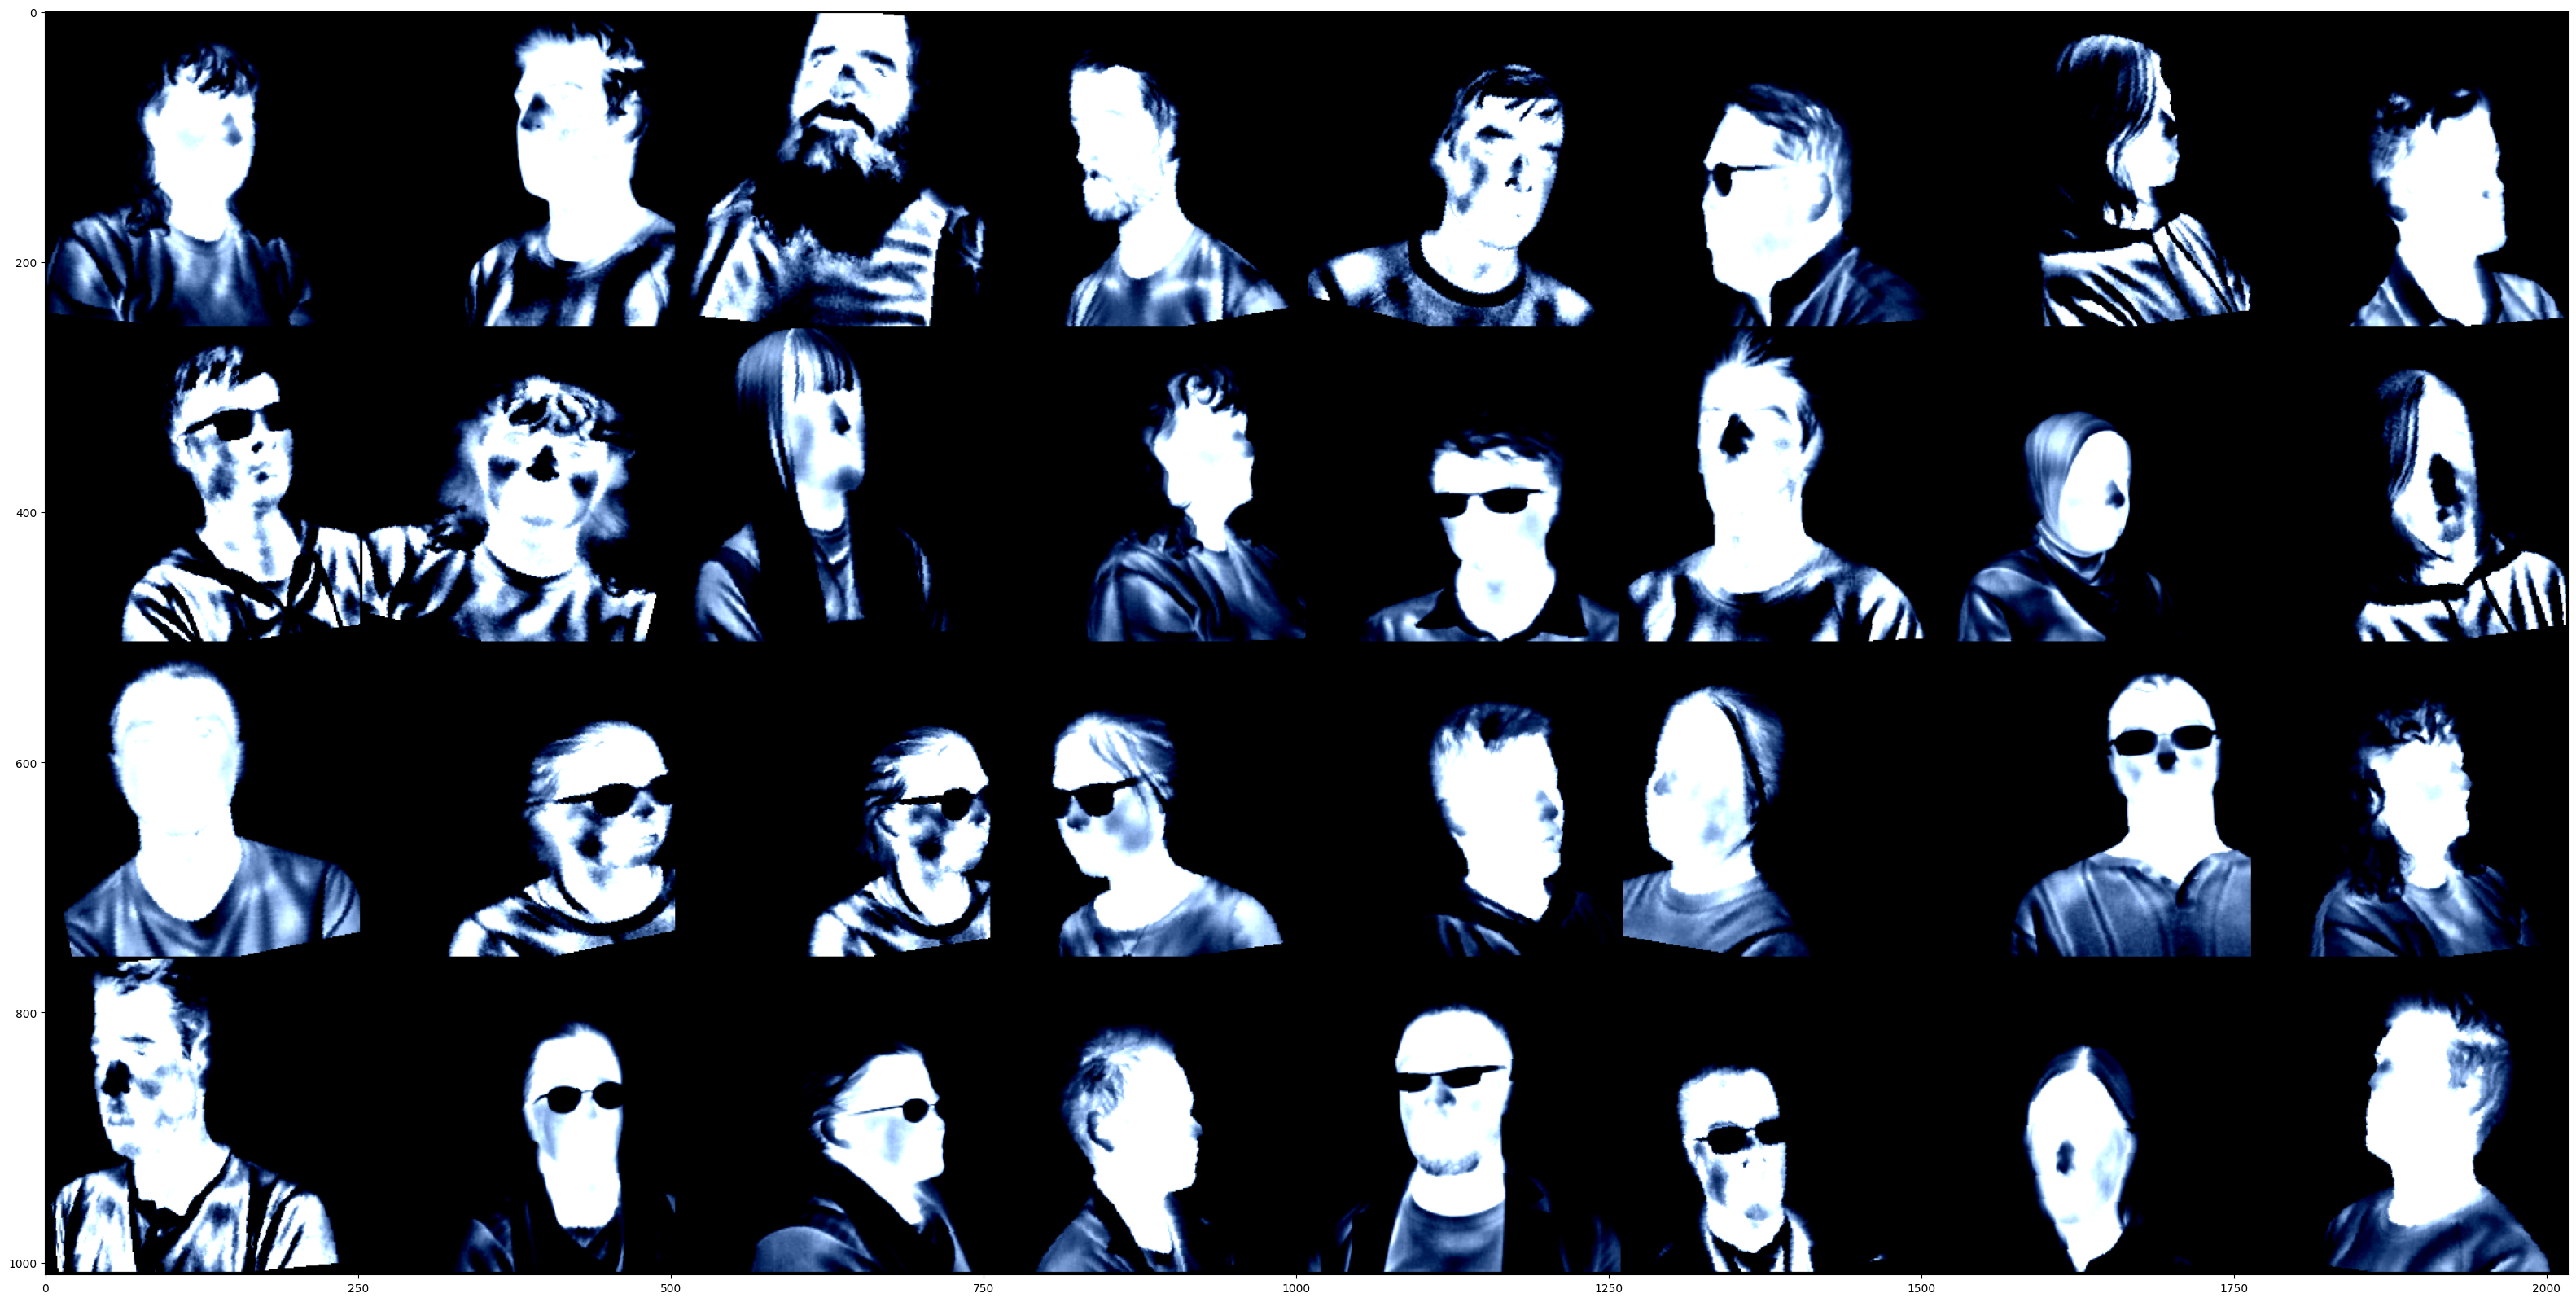

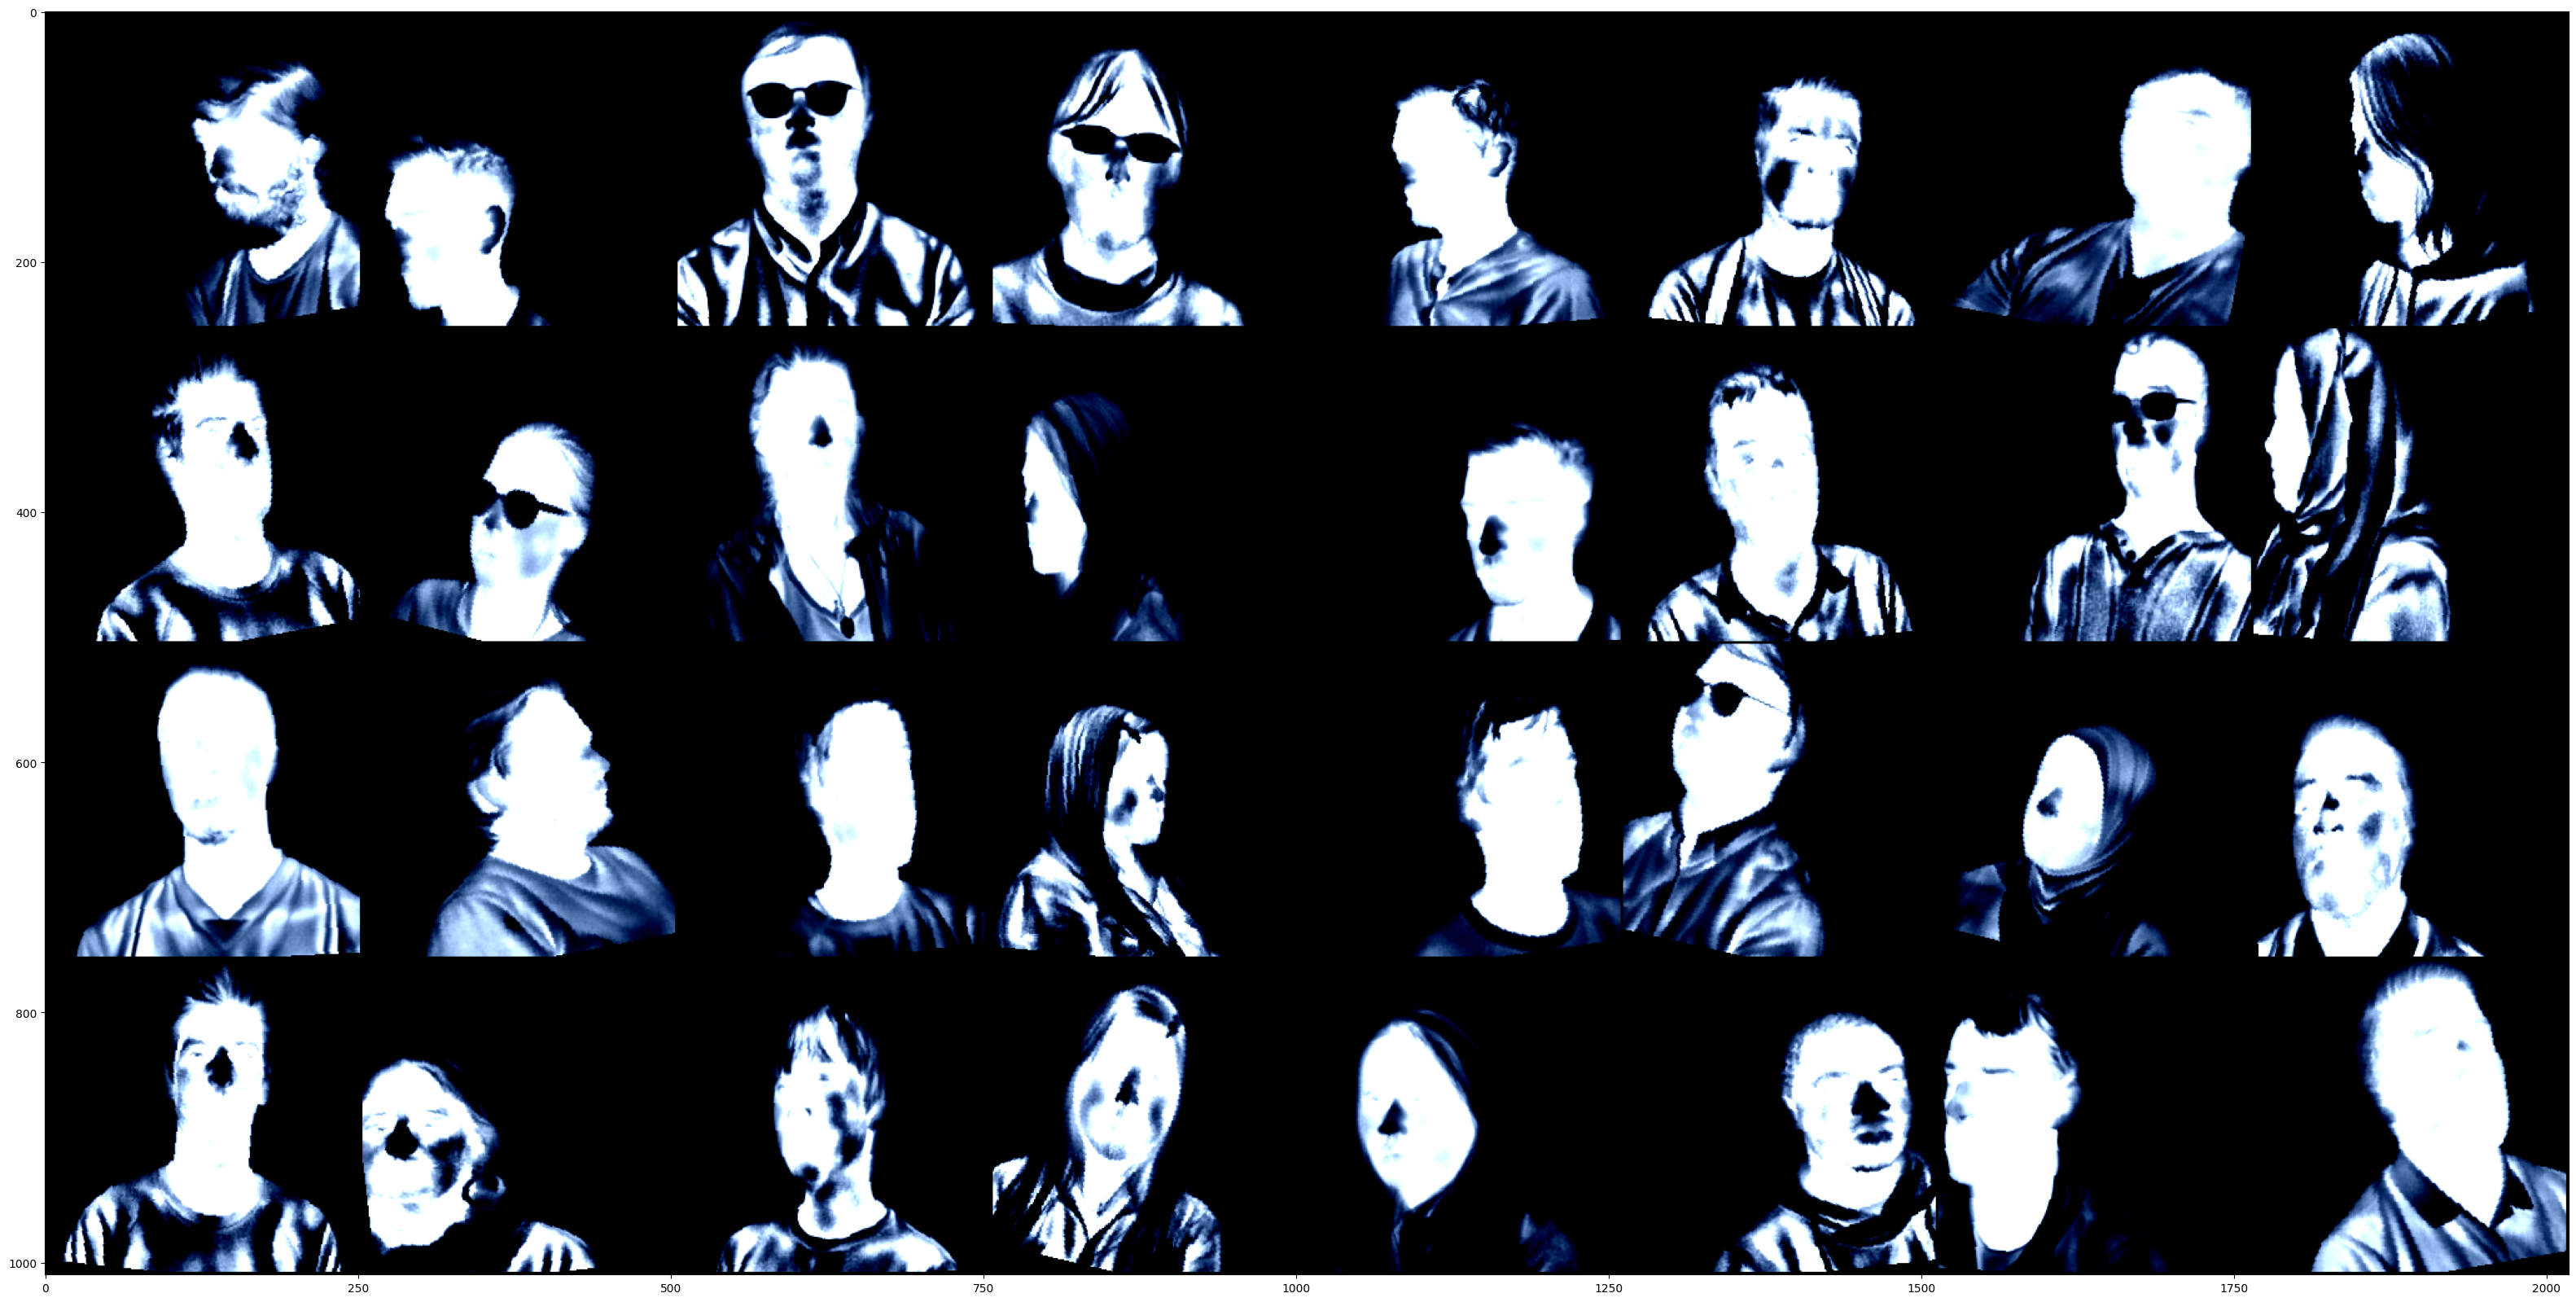

Prediction 1: Class 'MALE' with probability 0.9697335958480835
Prediction 2: Class 'FEMALE' with probability 0.030266428366303444


In [32]:
# Script for testing a model on a particular test image
from PIL import Image

dataset = 'Data/test'
model = torch.load('Data_Model_24.pt')
plt.ioff()
plt.show()

predict(model, 'Data/test/FEMALE/9.jpg')


# Load Data from folders
#computeTestSetAccuracy(model, loss_func)
        